In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
import pickle
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt
from pylab import *
from keras.callbacks import LearningRateScheduler
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
%cd /content/gdrive/MyDrive/CS_2

/content/gdrive/MyDrive/CS_2


## Data

In [4]:
data=pd.read_csv('data_wl')

In [5]:
data.head()

,Source,Target_inp,Target_out
0,"U wan me to ""chop"" seat 4 u nt?",<start> Do you want me to reserve seat for you...,Do you want me to reserve seat for you or not?...
1,Yup. U reaching. We order some durian pastry a...,<start> Yeap. You reaching? We ordered some Du...,Yeap. You reaching? We ordered some Durian pas...
2,They become more ex oredi... Mine is like 25.....,<start> They become more expensive already. Mi...,They become more expensive already. Mine is li...
3,I'm thai. what do u do?,<start> I'm Thai. What do you do?,I'm Thai. What do you do? <end>
4,Hi! How did your week go? Haven heard from you...,<start> Hi! How did your week go? Haven't hear...,Hi! How did your week go? Haven't heard from y...


In [6]:
tr,val = train_test_split(data, test_size=0.1) # as we have very less data to work with, we use major portion to train the data.

In [7]:
embedding_matrix=pickle.load(open('embed_mat.pkl','rb'))
tokenizer=pickle.load(open('tokenizer.pkl','rb'))

In [8]:
vocab_size=(len(tokenizer.word_index)+1)

In [9]:
vocab_size,embedding_matrix.shape

(3592, (3592, 300))

In [10]:
# Assigning token digits to every word in a sentence
Source_seq_tr = tokenizer.texts_to_sequences(tr['Source']) 
Target_inp_seq_tr = tokenizer.texts_to_sequences(tr['Target_inp'])
Target_out_seq_tr = tokenizer.texts_to_sequences(tr['Target_out'])

Source_seq_val = tokenizer.texts_to_sequences(val['Source'])
Target_inp_seq_val = tokenizer.texts_to_sequences(val['Target_inp'])
Target_out_seq_val = tokenizer.texts_to_sequences(val['Target_out'])

In [11]:
l=[]
for i in Source_seq_tr:
    l.append(len(i))
max_len=max(l)

In [12]:
l=[]
for i in Target_inp_seq_tr:
    l.append(len(i))
max_len_dec_ip=max(l)

l=[]
for i in Target_out_seq_tr:
    l.append(len(i))
max_len_dec_op=max(l)

max_len_dec=max(max_len_dec_ip,max_len_dec_op)

In [13]:
#Padding the sentences with zeros so that all sentences are of equal length
target_inp_tr = pad_sequences(Target_inp_seq_tr,  maxlen=max_len_dec, padding='post')
target_out_tr = pad_sequences(Target_out_seq_tr, maxlen=max_len_dec, padding='post')
Source_inp_tr = pad_sequences(Source_seq_tr, maxlen=max_len, padding='post')

target_inp_val = pad_sequences(Target_inp_seq_val,  maxlen=max_len_dec, padding='post')
target_out_val = pad_sequences(Target_out_seq_val, maxlen=max_len_dec, padding='post')
Source_inp_val = pad_sequences(Source_seq_val, maxlen=max_len, padding='post')

### Custom Functions:

In [14]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units,input_length):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, trainable=True, weights=[embedding_matrix], name="embedding_layer_encoder")
        self.lstm = Bidirectional(LSTM(self.enc_units, return_state=True, return_sequences=True, name='Encoder_LSTM2'))
        
    def call(self, input_sentances, training=True):
        input_embedd                           = self.embedding(input_sentances)
        self.lstm_output, lstm_state_h_f, lstm_state_c_f, lstm_state_h_b, lstm_state_c_b = self.lstm(input_embedd)
        self.lstm_state_h = Concatenate()([lstm_state_h_f, lstm_state_h_b])
        self.lstm_state_c = Concatenate()([lstm_state_c_f, lstm_state_c_b])
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c

    def initialize_states(self, batch_size):
        return tf.zeros((batch_size, self.enc_units)), tf.zeros((batch_size, self.enc_units))

    def get_states(self):
        return self.lstm_state_h,self.lstm_state_c

In [15]:
class Attention(tf.keras.layers.Layer):
    
    def __init__(self,scoring_function, att_units):
        super(Attention,self).__init__()
        self.scoring_function = scoring_function
        self.att_units = att_units
        if self.scoring_function=='dot':
            self.dot = tf.keras.layers.Dot(axes=[2,2])
        elif scoring_function == 'general':
            self.WG = Dense(self.att_units)
        elif scoring_function == 'concat':
            self.W1 = Dense(att_units)
            self.W2 = Dense(att_units)
            self.V = Dense(1)
  
    def call(self,decoder_hidden_state,encoder_output):        
        decoder_hidden_state = tf.expand_dims(decoder_hidden_state, axis=1)    
        if self.scoring_function == 'dot':
            score = self.dot([encoder_output, decoder_hidden_state])
        elif self.scoring_function == 'general':          
            score = tf.keras.layers.Dot(axes=[2, 2])([self.WG(encoder_output), decoder_hidden_state])
        elif self.scoring_function == 'concat':
            score = self.V(tf.nn.tanh(self.W1(decoder_hidden_state) + self.W2(encoder_output)))
        attention_weights = Softmax(axis=1)(score)     
        context_vector = attention_weights * encoder_output
        # shape = (batch_size, dec lstm units)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [16]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self, tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units): 
        super(One_Step_Decoder,self).__init__()
        self.vocab_size = tar_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        self.embedding = Embedding(self.vocab_size, self.embedding_dim, trainable=True, weights=[embedding_matrix], input_length=self.input_length, mask_zero=True, name="Att_Dec_Embedding")
        self.lstm = LSTM(self.dec_units, return_sequences=True, return_state=True, name="Att_Dec_LSTM")
        self.fc = Dense(self.vocab_size)
        self.attention = Attention(self.score_fun,self.att_units)
    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        embedded_input = self.embedding(input_to_decoder)
        context_vector, attention_weights = self.attention(state_h, encoder_output)
        decoder_input = tf.concat([tf.expand_dims(context_vector, 1), embedded_input], axis=-1)
        decoder_output, dec_state_h, dec_state_c = self.lstm(decoder_input, initial_state=[state_h, state_c])
        decoder_output = tf.reshape(decoder_output, (-1, decoder_output.shape[2]))
        output = self.fc(decoder_output)
        return output, dec_state_h, dec_state_c, attention_weights, context_vector

In [17]:
class Decoder(tf.keras.Model):  
    def __init__(self,out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units):
        super(Decoder,self).__init__()
        self.vocab_size = out_vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.dec_units = dec_units
        self.score_fun = score_fun
        self.att_units = att_units
        self.onestepdecoder = One_Step_Decoder(self.vocab_size, self.embedding_dim, self.input_length,
                                            self.dec_units, self.score_fun, self.att_units)
    def call(self, input_to_decoder,encoder_output,decoder_hidden_state,decoder_cell_state): 
        all_outputs = tf.TensorArray(tf.float32, size=input_to_decoder.shape[1])
        for timestep in range(input_to_decoder.shape[1]):
            output, decoder_hidden_state, decoder_cell_state, attention_weights, context_vector = self.onestepdecoder(
                input_to_decoder[:, timestep:timestep+1], encoder_output, decoder_hidden_state, decoder_cell_state)
            all_outputs = all_outputs.write(timestep, output)
        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])
        return all_outputs

In [18]:
class Encoder_decoder(Model):
    def __init__(self, encoder_inputs_length,decoder_inputs_length,batch_size, output_vocab_size,score_fun):
        super().__init__() # https://stackoverflow.com/a/27134600/4084039
        self.batch_size=batch_size
        self.encoder = Encoder(vocab_size= vocab_size, embedding_dim=300, input_length=encoder_inputs_length, enc_units=128)
        self.decoder = Decoder(out_vocab_size= vocab_size, embedding_dim=300, input_length=decoder_inputs_length, dec_units=256, score_fun=score_fun, att_units=256)
    def call(self, data):
        input,output = data[0], data[1]
        enc_initial_states = self.encoder.initialize_states(self.batch_size)
        encoder_output, encoder_h, encoder_c = self.encoder(input,enc_initial_states)
        decoder_output   = self.decoder(output, encoder_output, encoder_h, encoder_c)
        return decoder_output

### Model

In [19]:
model = Encoder_decoder(encoder_inputs_length=max_len,decoder_inputs_length=max_len_dec,output_vocab_size= vocab_size, batch_size=16, score_fun='concat')

In [20]:
model.load_weights('weights3')

### predict

In [21]:
def predict(input_sentence):

  input_sequence=tokenizer.texts_to_sequences([input_sentence])
  inputs=pad_sequences(input_sequence, maxlen=max_len, padding='post')
  inputs=tf.convert_to_tensor(inputs)
  result=''
  units=128
  hidden=[tf.zeros((1,units))]
  encoder_output,hidden_state,cell_state=model.layers[0](inputs,hidden)
  dec_hidden=hidden_state
  dec_input=tf.expand_dims([tokenizer.word_index['<start>']],0)
  for t in range(202):
      predictions,dec_hidden,cell_state,attention_weights,context_vector=model.layers[1].onestepdecoder(dec_input,encoder_output,dec_hidden,cell_state)

      predicted_id=tf.argmax(predictions[0]).numpy()
      result+=tokenizer.index_word[predicted_id]+' '
      if tokenizer.word_index['<end>']==predicted_id :
          return result
      dec_input= tf.expand_dims([predicted_id],0)
  return result

# Division of Data based on BLEU Scores

## Validation data

In [65]:
#Calculating Bleu Sccore
import nltk.translate.bleu_score as bleu
bleu_score1=[]
for i in range(0,200):
  decoded_sent=predict(val.Source.values[i])
  bleu_score1.append(bleu.sentence_bleu(val.Target_out.values[i], decoded_sent))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [66]:
avg_bleu_score=sum(bleu_score1)/len(bleu_score1)
avg_bleu_score

0.7384674872294625

Classifying the data based on the BLEU Score

In [67]:
best=[]
medium=[]
poor=[]
for i in range(len(bleu_score1)):
    if bleu_score1[i] >= 0.9:
        best.append(tr.Source.values[i])
    elif 0.7 < bleu_score1[i] < 0.9:
        medium.append(tr.Source.values[i])
    else:
        poor.append(tr.Source.values[i])

In [68]:
len(best),len(medium),len(poor)

(6, 132, 62)

* No. of phrases with best BLEU Score are 6.

* No. of phrases with BLEU Score between 0.7 to 0.9 are 132.

* No. of phrases with BLEU Score less than 0.7 are 62.



In [69]:
s=[]
for i in range(len(bleu_score1)):
    if bleu_score1[i] >= 0.9:
        s.append([val.Source.values[i], predict(val.Source.values[i]), val.Target_out.values[i]])

In [71]:
for i in range(0,5):
    print('Source Sentence: ',s[i][0])
    print('predicted Sentence: ',s[i][1])
    print('Target Sentence: ',s[i][2] )
    print('---------------------------------------------')

Source Sentence:  What is mb
predicted Sentence:  Is it <end> 
Target Sentence:  What is mb? <end>
---------------------------------------------
Source Sentence:  Congrats. Study hard.
predicted Sentence:  Nothing is <end> 
Target Sentence:  Congratulations. Study hard. <end>
---------------------------------------------
Source Sentence:  go
predicted Sentence:  Go <end> 
Target Sentence:  Go. <end>
---------------------------------------------
Source Sentence:  No no leh.
predicted Sentence:  No no <end> 
Target Sentence:  No no. <end>
---------------------------------------------
Source Sentence:  U at marina?
predicted Sentence:  You at at <end> 
Target Sentence:  You are at Marina? <end>
---------------------------------------------


The above sentences have Best BLEU Score 

In [74]:
a=[]
for i in range(len(bleu_score1)):
    if 0.7 < bleu_score1[i] < 0.9:
        a.append([val.Source.values[i], predict(val.Source.values[i]), val.Target_out.values[i]])
for i in range(0,5):
    print('Source Sentence: ',a[i][0])
    print('predicted Sentence: ',a[i][1])
    print('Target Sentence: ',a[i][2] )
    print('---------------------------------------------')

Source Sentence:  i'll be late...will call u
predicted Sentence:  Maybe will working soon Take you <end> 
Target Sentence:  I'll be late. I will call you. <end>
---------------------------------------------
Source Sentence:  Thx 4 turning up. Hope u had a gd time. I had u
predicted Sentence:  Tomorrow at home up Ron you you I a a more Then I <end> 
Target Sentence:  Thanks for turning up. Hope you had a good time. I had you. <end>
---------------------------------------------
Source Sentence:  Den where is e nearest mrt station tt u can meet me?
predicted Sentence:  That is is the the 1 30 30 pm You you you <end> 
Target Sentence:  Then where is the nearest MRT station that you can meet me? <end>
---------------------------------------------
Source Sentence:  good afternoon,my dear friend!how have u been?
predicted Sentence:  Must an my friend yesterday if they you you <end> 
Target Sentence:  Good afternoon, my dear friend! How have you been? <end>
------------------------------------

These phrases have BLEU sccore of 0.7 to 0.9.

In [44]:
d=[]
for i in range(len(bleu_score1)):
    if bleu_score1[i] < 0.7:
        d.append([val.Source.values[i], predict(val.Source.values[i]), val.Target_out.values[i]])
for i in range(0,5):
    print('Source Sentence: ',d[i][0])
    print('predicted Sentence: ',d[i][0])
    print('Target Sentence: ',d[i][2] )
    print('---------------------------------------------')

Source Sentence:  Should b. If u wan u got 2 send in ur resume 2 e agency n think tomw got a 1hr product training. How u wan?
predicted Sentence:  Sigh and if you you you two before and even a a big down and and and Ben I've a a drink also cheaper Or you <end> 
Target Sentence:  Should be. If you want, you got to send in your resume to the agency and think tomorrow got a one hour product training. How you want? <end>
---------------------------------------------
Source Sentence:  Nope,Nothing special recently... More or less juz stayed at home n watch tv at night. I enjoy the channel u show at 9 pm.... Had yr lunch yet?
predicted Sentence:  Oh Maybe never lectures place and and got got got got got outside and I haven't a big I haven't chance at 4 30 30 pm guess haven't real start <end> 
Target Sentence:  Nope, nothing special recently. More or less just stayed at home and watched TV at night. I enjoy the Channel U show at 9 pm. Had your lunch yet? <end>
--------------------------------

These phrases have BLEU sccore less than 0.7.

We perform some analysis to identify characterstics leading to good and poor scores.

### Histogram of lengths of phrases

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


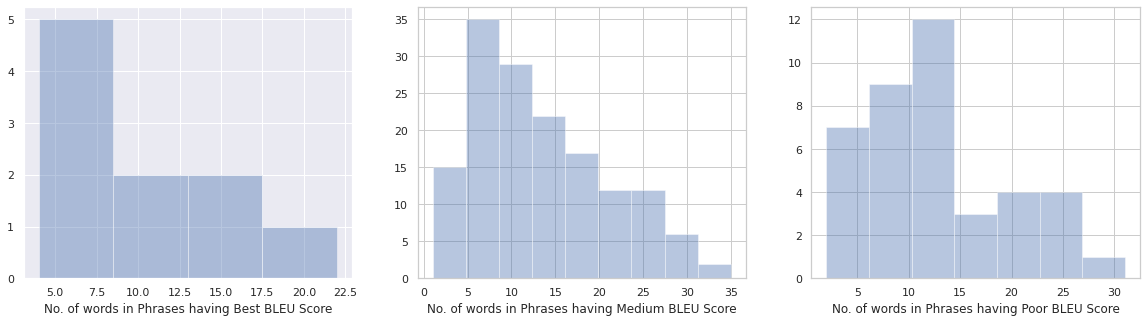

In [ ]:
sns.set(rc={"figure.figsize": (20,5)})

subplot(1,3,1)
b=pd.DataFrame(best,columns=['best'])
Source_words = b['best'].str.split().apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='No. of words in Phrases having Best BLEU Score')

subplot(1,3,2)
m=pd.DataFrame(medium,columns=['medium'])
Source_words = m['medium'].str.split().apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='No. of words in Phrases having Medium BLEU Score')

subplot(1,3,3)
p=pd.DataFrame(poor,columns=['poor'])
Source_words = p['poor'].str.split().apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='No. of words in Phrases having Poor BLEU Score')


plt.show()

**Observations:**

* The number of words in many phrases having best bleu score(>0.9) are around 5 to 8... Which means the phrases with less words are predicted well by the model.
* Phrases with more words have medium to less bleu score. 

### Histogram of length of Sentences

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


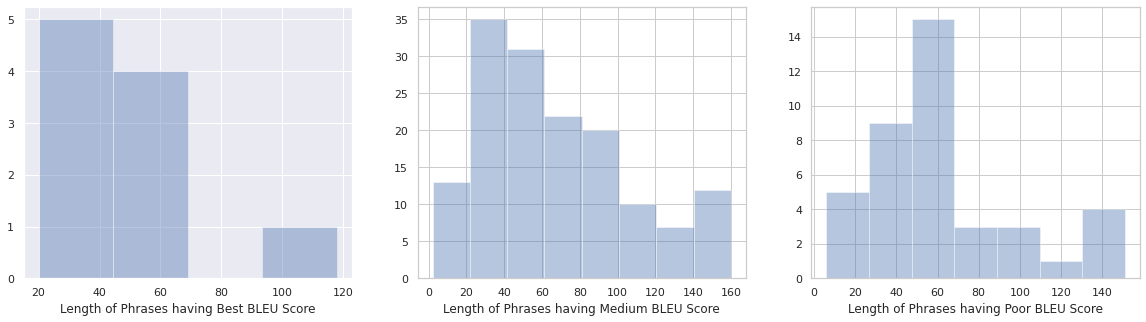

In [ ]:
sns.set(rc={"figure.figsize": (20,5)})

subplot(1,3,1)
b=pd.DataFrame(best,columns=['best'])
Source_words = b['best'].apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='Length of Phrases having Best BLEU Score')

subplot(1,3,2)
m=pd.DataFrame(medium,columns=['medium'])
Source_words = m['medium'].apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='Length of Phrases having Medium BLEU Score')

subplot(1,3,3)
p=pd.DataFrame(poor,columns=['poor'])
Source_words = p['poor'].apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='Length of Phrases having Poor BLEU Score')


plt.show()

**Observations:**
* The length is less for the well predicted phrases.

### Histogram of punctuations

In [ ]:
punc=['!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '/', ':', ';', '<', '=', '>', '?', '@', '[', '\\', ']', '^', '_', '`', '{', '|', '}', '~', '\t', '\n', '\r', '\x0b', '\x0c']

In [ ]:
def count_punc(c):
    lengt=[]
    for i in range(b.shape[0]):
        count=0
        for j in c[i]:
            for k in punc:
                if j==k:
                    count+=1
        lengt.append(count)
    return pd.Series(lengt)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


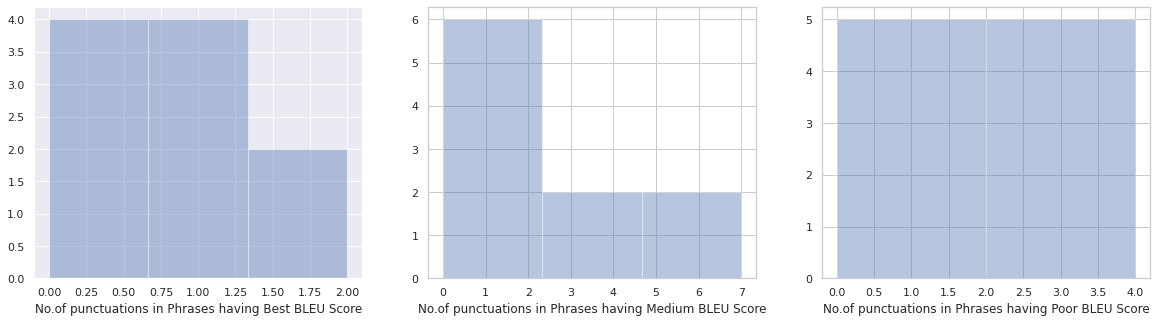

In [ ]:
sns.set(rc={"figure.figsize": (20,5)})

subplot(1,3,1)
b=pd.DataFrame(best,columns=['best'])
Count = count_punc(b['best'])
ax = sns.set_style('whitegrid')
ax = sns.distplot(Count,kde=False, axlabel='No.of punctuations in Phrases having Best BLEU Score')

subplot(1,3,2)
m=pd.DataFrame(medium,columns=['medium'])
Count = count_punc(m['medium'])
ax = sns.set_style('whitegrid')
ax = sns.distplot(Count,kde=False, axlabel='No.of punctuations in Phrases having Medium BLEU Score')

subplot(1,3,3)
p=pd.DataFrame(poor,columns=['poor'])
Count= count_punc(p['poor'])
ax = sns.set_style('whitegrid')
ax = sns.distplot(Count, kde=False, axlabel='No.of punctuations in Phrases having Poor BLEU Score')


plt.show()

**Observations:**
* The number of punctuation marks are less than or equal to 2 in phrases having 0.9 or above score.

## Train data

Similar Analysis can be performed on Train data.

In [45]:
import nltk.translate.bleu_score as bleu
bleu_score=[]
for i in range(tr.shape[0]):
  decoded_sent=predict(tr.Source.values[i])
  bleu_score.append(bleu.sentence_bleu(tr.Target_out.values[i], decoded_sent))

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [46]:
best=[]
medium=[]
poor=[]
for i in range(len(bleu_score)):
    if bleu_score[i] >= 0.9:
        best.append(tr.Source.values[i])
    elif 0.7 < bleu_score[i] < 0.9:
        medium.append(tr.Source.values[i])
    else:
        poor.append(tr.Source.values[i])

In [47]:
len(best),len(medium),len(poor)

(46, 1132, 615)

* No. of phrases with best BLEU Score are 46.

* No. of phrases with BLEU Score between 0.7 to 0.9 are 1132.

* No. of phrases with BLEU Score less than 0.7 are 615.



In [55]:
s=[]
for i in range(len(bleu_score)):
    if bleu_score[i] >= 0.9:
        s.append([tr.Source.values[i], predict(tr.Source.values[i]), tr.Target_out.values[i]])
for i in range(0,5):
    print('Source Sentence: ',s[i][0])
    print('predicted Sentence: ',s[i][1])
    print('Target Sentence: ',s[i][2] )
    print('---------------------------------------------')

Source Sentence:  Hey YUI
predicted Sentence:  Hey <end> 
Target Sentence:  Hey, Yui. <end>
---------------------------------------------
Source Sentence:  3:20 reached
predicted Sentence:  3 2 am <end> 
Target Sentence:  3:20 reached. <end>
---------------------------------------------
Source Sentence:  230
predicted Sentence:  230 <end> 
Target Sentence:  230 <end>
---------------------------------------------
Source Sentence:  Okie
predicted Sentence:  Ok <end> 
Target Sentence:  Ok. <end>
---------------------------------------------
Source Sentence:  ok!
predicted Sentence:  Ok <end> 
Target Sentence:  Ok! <end>
---------------------------------------------


The above sentences have Best BLEU Score 

In [61]:
a=[]
for i in range(len(bleu_score)):
    if 0.7 < bleu_score[i] < 0.9:
        a.append([tr.Source.values[i], predict(tr.Source.values[i]), tr.Target_out.values[i]])
for i in range(0,5):
    print('Source Sentence: ',a[i][0])
    print('predicted Sentence: ',a[i][1])
    print('Target Sentence: ',a[i][2] )
    print('---------------------------------------------')

Source Sentence:  Joey: Yup,where u fr?
predicted Sentence:  Joey Yes what you you <end> 
Target Sentence:  Joey: Yes, where are you from? <end>
---------------------------------------------
Source Sentence:  Thanks... You went bangkok? Got buy anything for me... Hee hee... Today you no school?
predicted Sentence:  Have you you just watching Sigh Don't asks me me and Ben else it is not <end> 
Target Sentence:  Thanks. You went to Bangkok? Got buy anything for me? Giggle. Today you have no school? <end>
---------------------------------------------
Source Sentence:  tt guy who is slightly taller than me tt time u saw me..
predicted Sentence:  That That is is slightly fine And and me and did you me <end> 
Target Sentence:  That guy who is slightly taller than me, that time you saw me. <end>
---------------------------------------------
Source Sentence:  Eh wanna come out for dinner? Me and deckie in suntec
predicted Sentence:  Ok Maybe have have back some with right and in in <end> 
Targ

These phrases have BLEU sccore of 0.7 to 0.9.

In [64]:
d=[]
for i in range(len(bleu_score)):
    if bleu_score[i] < 0.7:
        d.append([tr.Source.values[i], predict(tr.Source.values[i]), tr.Target_out.values[i]])
for i in range(0,5):
    print('Source Sentence: ',d[i][0])
    print('predicted Sentence: ',d[i][1])
    print('Target Sentence: ',d[i][2] )
    print('---------------------------------------------')

Source Sentence:  Izzit then y i got no base colour... Then mayb urs is 35 lor... Shall i get da pants dat i wanted fr u2... It's 26 now...
predicted Sentence:  Stars That I will I just no there together together and I will ask me and and I I would bring such tonight tonight this 3 30 30 30 pm <end> 
Target Sentence:  Is it? Then why I got no base color? Then maybe yours is 35. Shall I get the pants that I wanted from U2? It's 26 now. <end>
---------------------------------------------
Source Sentence:  Nay, no sports car for me... gotten into lotsa accidents for my love of speed. Furthermore, it's too ex for me already. So changed to a normal car. :)
predicted Sentence:  Ben no about tonight and me also got been got got got been no my anything light anything me and me and me also haven't to a a waitress <end> 
Target Sentence:  No, no sports car for me. I've gotten into lots of accidents for my love of speed. Furthermore, it's too expensive for me already. So I changed to a normal car

These phrases have BLEU sccore less than 0.7.

### Histogram of lengths of phrases

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


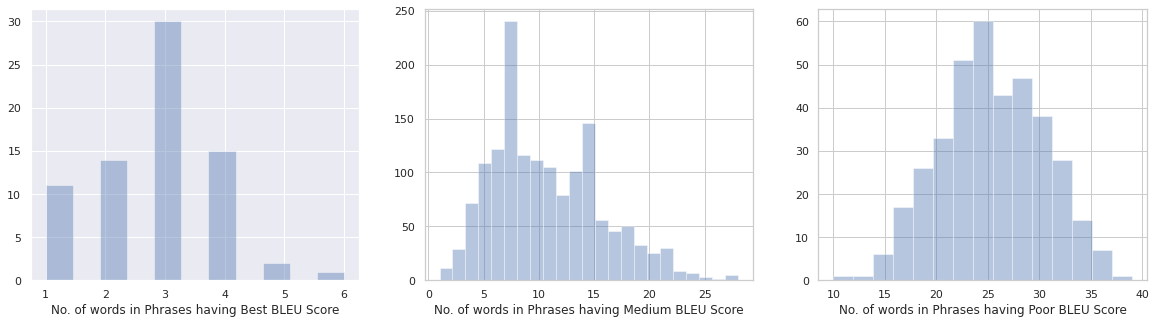

In [ ]:
sns.set(rc={"figure.figsize": (20,5)})

subplot(1,3,1)
b=pd.DataFrame(best,columns=['best'])
Source_words = b['best'].str.split().apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='No. of words in Phrases having Best BLEU Score')

subplot(1,3,2)
m=pd.DataFrame(medium,columns=['medium'])
Source_words = m['medium'].str.split().apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='No. of words in Phrases having Medium BLEU Score')

subplot(1,3,3)
p=pd.DataFrame(poor,columns=['poor'])
Source_words = p['poor'].str.split().apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='No. of words in Phrases having Poor BLEU Score')


plt.show()

### Histogram of length of Sentences

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


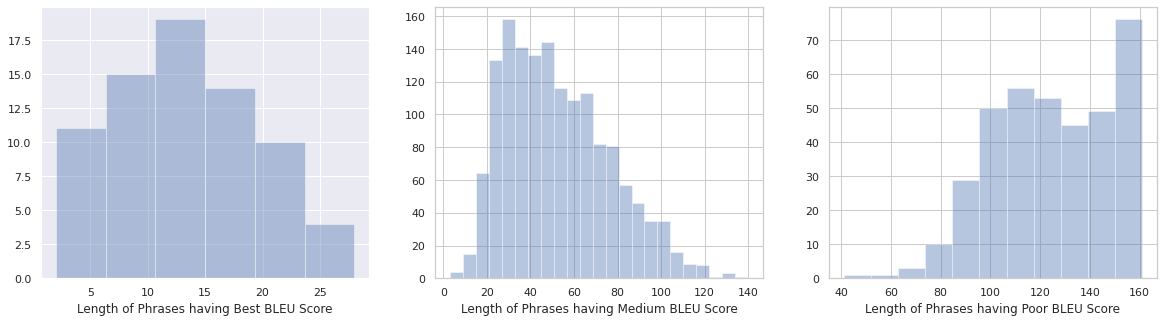

In [ ]:
sns.set(rc={"figure.figsize": (20,5)})

subplot(1,3,1)
b=pd.DataFrame(best,columns=['best'])
Source_words = b['best'].apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='Length of Phrases having Best BLEU Score')

subplot(1,3,2)
m=pd.DataFrame(medium,columns=['medium'])
Source_words = m['medium'].apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='Length of Phrases having Medium BLEU Score')

subplot(1,3,3)
p=pd.DataFrame(poor,columns=['poor'])
Source_words = p['poor'].apply(len)
ax = sns.set_style('whitegrid')
ax = sns.distplot(Source_words,kde=False, axlabel='Length of Phrases having Poor BLEU Score')


plt.show()

### Histogram of punctuations

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


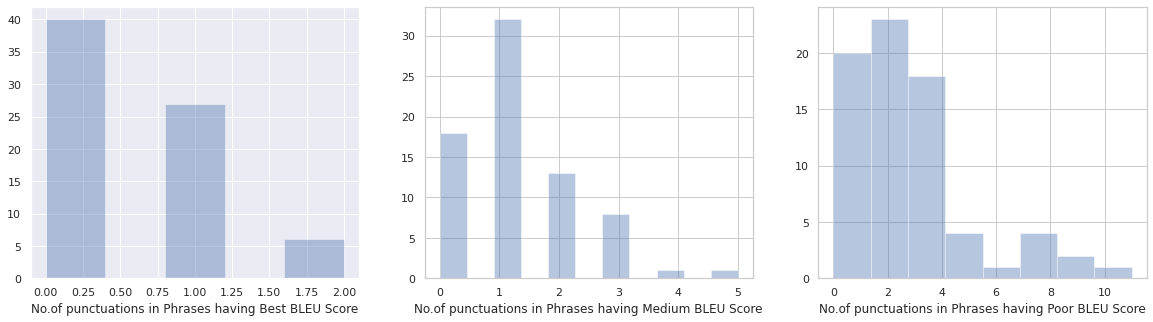

In [ ]:
sns.set(rc={"figure.figsize": (20,5)})

subplot(1,3,1)
b=pd.DataFrame(best,columns=['best'])
Count = count_punc(b['best'])
ax = sns.set_style('whitegrid')
ax = sns.distplot(Count,kde=False, axlabel='No.of punctuations in Phrases having Best BLEU Score')

subplot(1,3,2)
m=pd.DataFrame(medium,columns=['medium'])
Count = count_punc(m['medium'])
ax = sns.set_style('whitegrid')
ax = sns.distplot(Count,kde=False, axlabel='No.of punctuations in Phrases having Medium BLEU Score')

subplot(1,3,3)
p=pd.DataFrame(poor,columns=['poor'])
Count= count_punc(p['poor'])
ax = sns.set_style('whitegrid')
ax = sns.distplot(Count, kde=False, axlabel='No.of punctuations in Phrases having Poor BLEU Score')


plt.show()

**Observations:**
* Same as in test data analysis, In train data analysis also, Similar Characterstics are responsible for variations in score.
Like the sentences with more punctuations and more length are having bleu score less than 0.7.
* The sentences with very less or no punctuations, less length and less number of words are having bleu score greater than 0.9.